## EJERCICIO 3: MODELO DE SIMULACIÓN. VERBOSE Y RESULTADOS.

#### CARGA DE BIBLIOTECAS

In [21]:
import sqlite3      
import matplotlib.pyplot as plt
import fitter as ft
import simpy as sim
import numpy as np
import datetime as dt
import pandas as pd
from scipy.stats import f
from math import ceil
from tqdm import tqdm


## **DATOS**

In [22]:
worked_minutes = 8*60  

# CONSULTAS A LA BASE DE DATOS

conexion=sqlite3.connect("/Users/lucianosmith/Documents/Investigación Operativa 3/2C2024/Python/C07/integrador.db")

# PLAN DE PRODUCCIÓN

# fecha de inicio de la planificacion y final de planificación

m = conexion.execute(f"select min(sch_startdate) from schedule;")

start_date = dt.datetime.strptime(m.fetchall()[0][0], '%Y-%m-%d %H:%M:%S')

m = conexion.execute(f"select max(sch_enddate) from schedule;")

end_date = dt.datetime.strptime(m.fetchall()[0][0], '%Y-%m-%d %H:%M:%S')

# SECUENCIAS

# secuencia incial (lote, producto, cantidad, siguiente_wc, color)

start_seq = {}  # secuencia inicial
seq = {}        # secuencia completa

m = conexion.execute(f"select sch_task, sch_lot, sch_product, sal_qty, (select p.prs_workcenter from process p where p.prs_product = sch_product and p.prs_prev=x.prs_code), sch_color from schedule, process x, sales where sal_so=sch_lot and x.prs_workcenter=sch_task and x.prs_product=sch_product and x.prs_prev=-1 order by sch_startdate asc;")

for i in m.fetchall():
    if i[0] in start_seq: 
        start_seq[i[0]].append((i[1], i[2], i[3], i[4], i[5])) # si existe el worck center hace un append
        seq[i[0]].append((i[1], i[2], i[3], i[4], i[5]))
    else:
        start_seq.update({i[0]: [(i[1], i[2], i[3], i[4], i[5])]})
        seq.update({i[0]: [(i[1], i[2], i[3], i[4], i[5])]})

# secuencia completa

m = conexion.execute(f"select sch_task, sch_lot, sch_product, sal_qty, (select p.prs_workcenter from process p where p.prs_product = sch_product and p.prs_prev=x.prs_code), sch_color from schedule, process x, sales where sal_so=sch_lot and x.prs_workcenter=sch_task and x.prs_product=sch_product and x.prs_prev>-1 order by sch_startdate asc;")

for i in m.fetchall():
    if i[0] in seq: 
        seq[i[0]].append((i[1], i[2], i[3], i[4], i[5])) 
    else:
        seq.update({i[0]: [(i[1], i[2], i[3], i[4], i[5])]})

# DATOS DE LOS PROCESOS

# areas y cantidad de empleados

wc = {}
wcq = conexion.execute(f"select woc_code, woc_employees from work_center;")
for i in wcq:
    wc.update({i[0]: i[1]})

# tiempos de los procesos (por producto) 

m = conexion.execute(f"select prs_product, prs_workcenter, prs_time, prs_deviation, prs_distribution from process;")

t_process = {}

for i in m.fetchall(): 
        t_process.update({(i[0], i[1]): (i[4], i[2], i[3])})

# consumo de materia prima (por proceso y producto)

m = conexion.execute(f"select prs_product, prs_workcenter, prs_rawqty from process;")

t_rawqty = {}

for i in m.fetchall(): 
        t_rawqty.update({(i[0], i[1]): i[2]})

# matriz de cambio de color (pintura)

m = conexion.execute(f"select c1.col_desc, c2.col_desc, cot_time from color_table, colors c1, colors c2 where c1.col_code = cot_orig and c2.col_code = cot_dest;")

setup_color_matrix = {}

for i in m.fetchall(): 
        setup_color_matrix.update({(i[0], i[1]): (i[2])})     

# ausentismo para el area de CORTE

a = conexion.execute(f"select count(*) from attendance where att_attendance = 1 and att_workcenter = 'CORTE';")
b = conexion.execute(f"select count(*) from attendance where att_workcenter = 'CORTE';")
p_ausentismo = 1-(a.fetchall()[0][0]/b.fetchall()[0][0])

# feriados

s = conexion.execute(f"select * from feriados;")
holidays = []
for i in s.fetchall():
    holidays.append( (i[0],i[1],i[2]) )

# INFORMACION DE ALMACENAMIENTO

# stock de materia prima

s = conexion.execute(f"select * from stock;")
stk = {}
for i in s.fetchall():
    stk.update({i[1]: i[3]})

# reaprovisionamiento

def get_min(fecha):
    diff = fecha - start_date
    min = 0
    day = start_date
    for d in range(diff.days):        
        if (day.weekday()<5) and ((day.day, day.month, day.year) not in holidays): 
            min += worked_minutes
        day = day + dt.timedelta(days=1)
    return min

reaprovisionamiento = []

s = conexion.execute(f"select * from to_receive where tre_status='waiting' order by tre_date asc;")

t0 = 0
for i in s.fetchall():
    tt = get_min(dt.datetime.strptime(i[4], '%Y-%m-%d'))
    reaprovisionamiento.append((tt-t0, i[2], i[3]))
    t0 = tt

# AJUSTE DE TIEMPOS DE MANTENIMIENTO

# DOBLADORA (TTR)

m = conexion.execute(f"select mai_ttr from maintenance where mai_machine='DOBLADORA' and mai_type='C';")
d_ttr = [i[0] for i in m.fetchall()] 

# ajuste y obtención de parámetros

f2 = ft.Fitter(d_ttr, bins=20, timeout=100, distributions=['norm', 'expon', 'weibull_max','weibull_min'])
f2.fit()

u_ttr = f2.get_best()['norm'][0]
d_ttr = f2.get_best()['norm'][1]

# DOBLADORA (TBF)

m = conexion.execute(f"select mai_tbf from maintenance where mai_machine='DOBLADORA' and mai_type='C';")
d_tbf = [i[0] for i in m.fetchall()] 

# ajuste y obtención de parámetros
f1 = ft.Fitter(d_tbf, bins=20, timeout=100, distributions=['norm', 'expon','beta', 'f'])
f1.fit()

a_tbf = f1.get_best()['f'][0]
b_tbf = f1.get_best()['f'][1]
c_tbf = f1.get_best()['f'][2]
d_tbf = f1.get_best()['f'][3]

conexion.close()


## **MODELO DE SIMULACIÓN**

In [23]:
# definición de colores

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

class modelo1:
   
    def __init__(self, start_date, start_seq, seq, wc, t_process, t_rawqty, setup_color_matrix, p_ausentismo, holidays, stk, reaprov, u_ttr, d_ttr, a_tbf, b_tbf, c_tbf, d_tbf, verbose, tmax):

        self.env = sim.Environment()
        
        # PARÁMETROS

        self.worked_minutes = 8*60
        self.verbose = verbose                                       
        self.setup_color = 'rojo'   
        self.mant = False
        self.last_maintenance = 900
        
        self.continuar = True

        # parametros enviados
        self.start_date = start_date
        self.start_seq = start_seq
        self.seq = seq
        self.wc = wc
        self.t_process = t_process
        self.t_rawqty = t_rawqty
        self.setup_color_matrix = setup_color_matrix
        self.p_ausentismo = p_ausentismo
        self.holidays = holidays
        self.stk = stk
        self.reaprov = reaprov.copy()
        self.u_ttr = u_ttr
        self.d_ttr = d_ttr
        self.a_tbf = a_tbf
        self.b_tbf = b_tbf
        self.c_tbf = c_tbf
        self.d_tbf = d_tbf
        self.tmax = tmax

        # objetos creados
        self.wc.update({'terminado':1})                                                

        self.store = {}                                                                 
        for i in list(self.wc.keys()):
            self.store.update({i:sim.FilterStore(self.env)})

        self.raw_material = {}                                                          
        for i in self.stk:
            self.raw_material.update({i: sim.Container(self.env, init=self.stk[i])})

        self.workers = {}                                                               
        for i in list(self.wc.keys()):
            if i!='corte_m':
                self.workers.update({i: sim.Resource(self.env, capacity=self.wc[i])})
            else:
                self.workers_corte_m = sim.Container(self.env, capacity=self.wc[i], init=self.wc[i])

        for i in self.start_seq:                                                           
            for j in self.start_seq[i]:
                self.store[i].put([j[0], j[1]])

    # --------------------------------------------------------------------------------------------------------

    # FUNCIONES AUXILIARES

    def get_setupTime(self, next_color):                                               
        self.setup_color
        t = self.setup_color_matrix[(self.setup_color, next_color)]
        self.setup_color = next_color
        return t

    def get_processTime(self, prod, work_center, qty):                                
        t = 0
        dist, mean, std = self.t_process[(prod, work_center)]
        if dist == 1:
            t = np.sum([abs(np.random.normal(loc=mean, scale=std, size=qty))])     
        if dist == 2:
            t = np.sum([abs(np.random.uniform(low=mean, high=std, size=qty))])     
        return t
        
    def get_rawqty(self, prod, work_center, qty, color):                       
        raw_code = 'madera'
        if work_center=='corte_m': raw_code = 'metal'
        if work_center=='pintura': raw_code = color
        q = self.t_rawqty[(prod, work_center)]*qty
        return raw_code, q

    def get_date(self, env, tiempo=-1):
        if tiempo==-1: tiempo = self.env.now                                               
        dias = int(tiempo/self.worked_minutes)
        day = self.start_date
        day = day + dt.timedelta(days=1)
        while dias>0:    
            if (day.weekday()<5) and ((day.day, day.month, day.year) not in self.holidays): dias -= 1 
            day = day + dt.timedelta(days=1)
        day = day + dt.timedelta(days=-1)
        dif = ((tiempo/self.worked_minutes)-int(tiempo/self.worked_minutes))*self.worked_minutes/60
        if dif>3: dif += 1
        day = day + dt.timedelta(hours=9+dif)
        return day

    # funcion de impresión de eventos según el 
    # tipo de error y considerando el nivel de 
    # impresión requerido (verbose).

    def print_evt(self, env, type, lot, product, workcenter, msg):
        if (self.verbose>0) and (type<=self.verbose):
            if type==1: color = bcolors.FAIL                                # solo errores
            if type==2: color = bcolors.OKGREEN                             # finalización de producción (por area)
            if type==3: color = bcolors.WARNING                             # alertas
            if type==4: color = bcolors.HEADER                              # recursos humanos
            if type==5: color = bcolors.OKBLUE                              # movimientos de inventario
            if type==6: color = bcolors.OKCYAN                              # mantenimiento
            p_d = self.get_date(self.env).strftime("%d-%m-%Y, %H:%M:%S")    # obtiene y formatea la fecha de la simulación
            s = '['+workcenter.upper().center(8)+']'                       
            print(f'{color} [{str(int(self.env.now)).rjust(5)}],[{lot.ljust(7)}],[{product.ljust(8)}],{s},[{p_d}],{msg}')

    # --------------------------------------------------------------------------------------------------------

    # OPERACION ESTANDARIZADA

    def operation(self, env, work_center, product_code, lot, qty, next_wc, color):
    
        self.print_evt(self.env, type=3, lot=lot, product=product_code, workcenter=work_center, msg=f'ENTRANDO PARA FABRICAR {qty} UND.')
        
        # MANTENIMIENTO MAQUINA DE DOBLADO
        if (work_center == 'doblado') and (self.mant == True):
            self.print_evt(self.env, type=1, lot=lot, product=product_code, workcenter=work_center, msg=f'EN ESPERA POR MANTENIMIENTO.')
            while self.mant:yield self.env.timeout(1)

        # MATERIA PRIMA
        if work_center in ('corte_m', 'corte_w', 'pintura'):    
            raw_code, raw_q = self.get_rawqty(product_code, work_center, qty, color)
            self.print_evt(self.env, type=5, lot=lot, product=product_code, workcenter=work_center, msg=f'SOLICITANDO {raw_code.upper()} {(raw_q*qty):.2f} UND.')
            
            req_mp = self.raw_material[raw_code].get(qty*raw_q)
            
            try: 
                _ = req_mp.ok
            except:
                self.print_evt(self.env, type=1, lot=lot, product=product_code, workcenter=work_center, msg=f'SIN STOCK DE {raw_code.upper()} ({(self.raw_material[raw_code].level):.2f}).SE REQUIEREN {(raw_q*qty):.2f} UND.')

            yield req_mp


            self.print_evt(self.env, type=3, lot=lot, product=product_code, workcenter=work_center, msg=f'ALMACÉN DE {raw_code.upper()} QUEDA EN {(self.raw_material[raw_code].level):.2f}  UND.')
                
        # REQUERIMIENTO DE MANO DE OBRA
        self.print_evt(self.env, type=3, lot=lot, product=product_code, workcenter=work_center, msg=f'SOLICITANDO OPERARIO.')
        if work_center!='corte_m':
            worker_req = self.workers[work_center].request()
            yield worker_req
        else:
            if self.workers_corte_m.level==0:
                self.print_evt(self.env, type=1, lot=lot, product=product_code, workcenter=work_center, msg=f'EN ESPERA POR OPERARIO.')
            while self.workers_corte_m.level==0:
                jj = ceil(self.env.now/self.worked_minutes)
                yield self.env.timeout( (jj*self.worked_minutes) - self.env.now + 1 )
            yield self.workers_corte_m.get(1)
        
        # SETUP (PINTURA)
        if work_center=='pintura':
            self.print_evt(self.env, type=6, lot=lot, product=product_code, workcenter=work_center,  msg=f'REALIZANDO SETUP.')
            yield self.env.timeout(self.get_setupTime(color))
            self.print_evt(self.env, type=6, lot=lot, product=product_code, workcenter=work_center,  msg=f'SETUP FINALIZADO.')
        
        # PROCESO DE PRODUCTO
        self.print_evt(self.env, type=3, lot=lot, product=product_code, workcenter=work_center,  msg=f'PROCESANDO {qty} UND.')
        process_time = self.get_processTime(product_code, work_center, qty)
        yield self.env.timeout(process_time)
        self.print_evt(self.env, type=2, lot=lot, product=product_code, workcenter=work_center,  msg=f'TEMINÓ DE PROCESAR {qty} UND.')
        if (next_wc=='terminado'):
            self.print_evt(self.env, type=2, lot=lot, product=product_code, workcenter=work_center, msg=f'{bcolors.ENDC}LOTE {next_wc.upper()}!!{bcolors.ENDC}')
        else:
            self.print_evt(self.env, type=3, lot=lot, product=product_code, workcenter=work_center, msg=f'PASA A SIGUIENTE OPERACION {next_wc.upper()}.')


        # LIBERA MANO DE OBRA
        if work_center!='corte_m':
            yield self.workers[work_center].release(worker_req)
        else:
            yield self.workers_corte_m.put(1)

        # AGREGA EL SEMIELABORADO/TERMINADO EN EL ALMACEN CORRESPONDIENTE
        yield self.store[next_wc].put([lot, product_code])

        # CONTROL DE FINALIZACIÓN
        if ((next_wc=='terminado') and (len(self.store['terminado'].items)>=len(self.seq['despacho']))) or (self.env.now>self.tmax):
            self.continuar = False
            self.end_date = self.get_date(self.env)
            self.end_min = self.env.now
    
    # --------------------------------------------------------------------------------------------------------

    # FUNCIONES PRINCIPALES
    
    def main_operation(self, env, work_center):
        lote_idx = 0
        while self.continuar:
            # busca y remueve el siguiente semielaborado disponible
            i1 = yield self.store[work_center].get(lambda i: i[0]==self.seq[work_center][lote_idx][0]) 
            prod = self.seq[work_center][lote_idx][1]
            lot = self.seq[work_center][lote_idx][0]
            qty = self.seq[work_center][lote_idx][2]
            next_wc = self.seq[work_center][lote_idx][3]
            color = self.seq[work_center][lote_idx][4]
            if next_wc is None: next_wc = 'terminado'
            env.process(self.operation(env, work_center, prod, lot, qty, next_wc, color))
            lote_idx += 1
            if (lote_idx>=len(self.seq[work_center])): break

    def ausentismo(self, env):
        while self.continuar:
            ausentes = sum(np.random.choice(a=[1,0], p=[self.p_ausentismo, 1-self.p_ausentismo], size=self.workers_corte_m.capacity))
            if ausentes>0:                    
                yield self.workers_corte_m.get(ausentes)
                self.print_evt(self.env, type=1, lot='', product='', workcenter='CORTE_M',  msg=f'AUSENTISMO {ausentes} OPERARIO/S.')
                yield self.env.timeout(self.worked_minutes-1)
                yield self.workers_corte_m.put(ausentes)                    
                self.print_evt(self.env, type=1, lot='', product='', workcenter='CORTE_M',  msg=f'FIN DE DIA DE AUSENTISMO.')
            yield self.env.timeout(    (ceil(self.env.now/self.worked_minutes)*self.worked_minutes) - self.env.now  )

                    
    def reaprovisionamiento(self, env):
        self.next_reaprov = self.reaprov[0]
        while self.continuar:
            self.reaprov.remove(self.next_reaprov)
            yield self.env.timeout(self.next_reaprov[0])
            self.print_evt(self.env, type=5, lot='', product='', workcenter='', msg=f'ALTA DE STOCK {self.next_reaprov[1].upper()} {self.next_reaprov[2]:.2f} UND. TOTAL: {self.raw_material[self.next_reaprov[1]].level:.2f}.')
            self.raw_material[self.next_reaprov[1]].put(self.next_reaprov[2])
            if len(self.reaprov) == 0: break
            self.next_reaprov = self.reaprov[0]
    
    # --------------------------------------------------------------------------------------------------------
    
    def mantenimiento(self, env):
        self.next_fail = 1200 # abs(f.rvs(self.a_tbf, b_tbf, c_tbf, d_tbf)-self.last_maintenance) # lo fijo para generar una demora intencional
        while self.continuar:
            yield self.env.timeout(self.next_fail)
            self.ttr = abs(np.random.normal(self.u_ttr,self.d_ttr))
            self.print_evt(self.env, type=6, lot='', product='', workcenter='DOBLADO', msg=f'EN MANTENIMIENTO.')
            self.mant = True
            yield self.env.timeout(self.ttr)
            self.next_fail = abs(f.rvs(self.a_tbf, b_tbf, c_tbf, d_tbf))
            self.print_evt(self.env, type=6, lot='', product='', workcenter='DOBLADO', msg=f'MANTENIMIENTO FINALIZADO.')
            self.mant = False
            if self.next_fail>10000: break

    def run(self):

        self.env.process(self.ausentismo(self.env))

        for i in list(self.wc.keys())[:-1]:
            self.env.process(self.main_operation(self.env, i)) 

        self.env.process(self.reaprovisionamiento(self.env))

        self.env.process(self.mantenimiento(self.env))

        self.env.run()
        
        return self.end_min


## EJECUCIÓN DEL MODELO

##### convertir en bloque Python para activar la generación de una normal (y comentar la activacion de mantenimiento, reaprovisionamiento y ausentismo en la función "run")

stk = {'madera': 15000,
 'metal': 70000,
 'laca': 7000,
 'blanco': 1000,
 'crema': 8000,
 'marron': 5500,
 'dorado': 1200,
 'rojo': 5000,
 'aluminio': 4200,
 'negro': 1000}

In [24]:
sim_end = []                                                   # lista que guardará los tiempos de cada simulación
verbose = 0                                                    # 99 todas, 0 ninguna
iter = 3000                                                    # número de iteraciones

for i in  tqdm(range(iter)):

    s = modelo1(start_date = start_date, 
                start_seq = start_seq,
                seq = seq, 
                wc = wc, 
                t_process = t_process, 
                t_rawqty = t_rawqty, 
                setup_color_matrix = setup_color_matrix, 
                p_ausentismo = p_ausentismo, 
                holidays = holidays, 
                stk = stk, 
                reaprov = reaprovisionamiento, 
                u_ttr = u_ttr, 
                d_ttr = d_ttr,
                a_tbf = a_tbf,
                b_tbf = b_tbf,
                c_tbf = c_tbf,
                d_tbf = d_tbf,
                verbose = verbose,
                tmax = 20000)
    
    end_min = s.run()
    sim_end.append(end_min)                                 # agrega el valor a la lista

    if verbose>0:
        print(f'{bcolors.ENDC}{bcolors.UNDERLINE}FECHA FINALIZACIÓN ÚLTIMO LOTE: {s.end_date.strftime("%d-%m-%Y, %H:%M:%S")} {s.end_min:.2f} (minutos).{bcolors.ENDC}')

        for i in stk:
            s1 = f'{bcolors.HEADER}STOCK ALMACEN {i.upper()}: '
            s2 = f'{s.raw_material[i].level:.2f} UND.'
            print(f'{s1.ljust(30)} {s2.rjust(15)}')



100%|██████████| 3000/3000 [00:09<00:00, 305.84it/s]


## **ANÁLISIS DE RESULTADOS I**

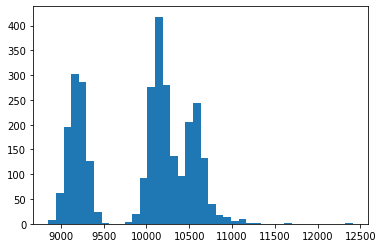

In [25]:
plt.hist(sim_end, bins=40, density=False)
plt.show()

**HASTA ACA B1**

,sumsquare_error,aic,bic,kl_div
norm,0.000005,772.234840,-60424.102683,inf
expon,0.000007,694.243534,-59832.281363,inf
weibull_min,0.000010,867.371606,-58556.382073,inf
weibull_max,0.000011,867.255590,-58331.636190,inf


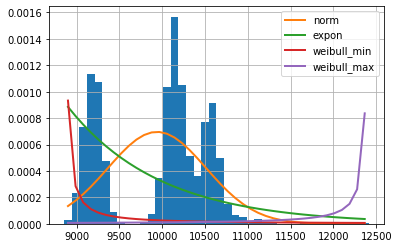

In [26]:
# ajuste y obtención de parámetros ...

ff = ft.Fitter(sim_end, bins=40, timeout=100, distributions=['norm', 'expon', 'weibull_max','weibull_min'])
ff.fit()

u = ff.get_best()['norm'][0]
d = ff.get_best()['norm'][1]

ff.summary()

In [27]:
time_max = max(sim_end)
time_min = min(sim_end)

In [28]:
def get_date(tiempo):
        dias = int(tiempo/s.worked_minutes)
        day = s.start_date
        day = day + dt.timedelta(days=1)
        while dias>0:    
            if (day.weekday()<5) and ((day.day, day.month, day.year) not in s.holidays): dias -= 1 
            day = day + dt.timedelta(days=1)
        day = day + dt.timedelta(days=-1)
        dif = ((tiempo/s.worked_minutes)-int(tiempo/s.worked_minutes))*s.worked_minutes/60
        if dif>3: dif += 1
        day = day + dt.timedelta(hours=9+dif)
        return day

In [29]:
# mini reporte:

print(f"distribución normal (u = {u:.2f}, d = {d:.2f})\n")

print(f'media = {u:.2f} min ({get_date(u).strftime("%d-%m-%Y, %H:%M:%S")})')
print(f'desvio = {d:.2f} min ({get_date(d).strftime("%d-%m-%Y, %H:%M:%S")})\n')

print(f'min = {time_min:.2f} min ({get_date(time_min).strftime("%d-%m-%Y, %H:%M:%S")})')
print(f'max = {time_max:.2f} min ({get_date(time_max).strftime("%d-%m-%Y, %H:%M:%S")})')


distribución normal (u = 9939.26, d = 573.28)

media = 9939.26 min (31-10-2024, 15:39:15)
desvio = 573.28 min (02-10-2024, 10:33:16)

min = 8854.73 min (29-10-2024, 13:34:43)
max = 12410.13 min (07-11-2024, 16:50:07)


In [30]:
from scipy.stats import norm

valor = 8159

# Calculamos la probabilidad P(X <= 8159)
probabilidad = norm.cdf(valor, loc=u, scale=d)
print(f'La probabilidad de terminar la producción antes del {get_date(valor).strftime("%d-%m-%Y, %H:%M:%S")} es de {100*probabilidad:.2f} %.')

La probabilidad de terminar la producción antes del 24-10-2024, 17:59:00 es de 0.10 %.


In [31]:
# Calculamos el valor de x que corresponde al percentil 90 (90% de probabilidad)
percentil_90 = norm.ppf(0.90, loc=u, scale=d)
print(f'Se podrá terminar la producción antes del {get_date(percentil_90).strftime("%d-%m-%Y, %H:%M:%S")} con una probabilidad de 90%.' )

Se podrá terminar la producción antes del 04-11-2024, 10:53:56 con una probabilidad de 90%.


**HASTA ACA B2**

## **ANÁLISIS DE RESULTADOS II**

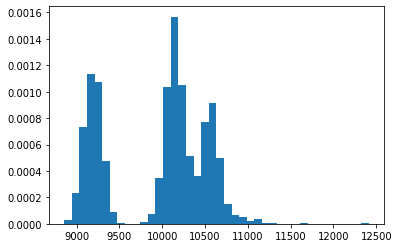

In [32]:
plt.hist(sim_end, bins=40, density=True)

#plt.axis("off")
plt.show()

El resultado no parece ser una **distribución paramétrica**. En principio la principal causa de esto se debe al **ausentismo**. Tenemos que utilizar métodos para distribuciones no parámetricos a fin de obtener la información que necesitamos.

**HASTA ACA B3**

In [33]:
print(f'min = {time_min:.2f} min ({get_date(min(sim_end)).strftime("%d-%m-%Y, %H:%M:%S")})')
print(f'max = {time_max:.2f} min ({get_date(max(sim_end)).strftime("%d-%m-%Y, %H:%M:%S")})')

min = 8854.73 min (29-10-2024, 13:34:43)
max = 12410.13 min (07-11-2024, 16:50:07)


In [34]:
valor = 8159

p = len([x for x in sim_end if x < valor])/len(sim_end)

print(f'La probabilidad de terminar la producción antes del {get_date(valor).strftime("%d-%m-%Y, %H:%M:%S")} es de {100*p:.2f} %.')

La probabilidad de terminar la producción antes del 24-10-2024, 17:59:00 es de 0.00 %.


In [35]:
fecha = np.percentile(sim_end, 90)

print(f'Se podrá terminar la producción antes del {get_date(fecha).strftime("%d-%m-%Y, %H:%M:%S")} con una probabilidad de 90%.' )


Se podrá terminar la producción antes del 04-11-2024, 09:42:40 con una probabilidad de 90%.
